<a href="https://colab.research.google.com/github/jalamie/homework/blob/main/Copy_of_NI_MVI_B231_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lets build our first Multilayer Perceptron from scratch in PyTorch!

In [ ]:
!nvidia-smi

Wed Oct 18 07:18:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# imports

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# check if we have GPU!

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

## Load our first dataset!

In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5), (0.5))
     ])

train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           download = True,
                                           transform = transform
                                           )

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 128,
                                           shuffle = True,
                                           drop_last = True
                                           )

val_dataset = torchvision.datasets.MNIST(root = './data',
                                         train = False,
                                         download = True,
                                         transform = transform
                                         )

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size = 128,
                                         shuffle = False,
                                         drop_last = True
                                         )

## A little turnoff:

In [ ]:
# how to create your own PyTorch dataset?

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

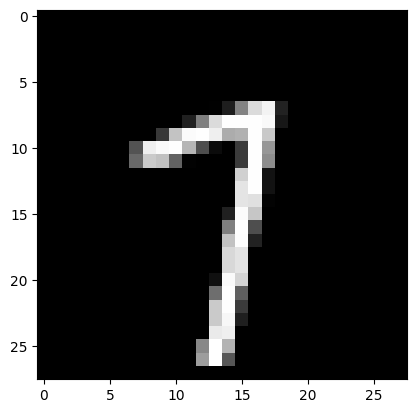

In [ ]:
plt.imshow(x_train[42], cmap='Greys_r')

In [ ]:
y_train[42]

7

In [ ]:
# torch.tensor(x_train)

In [ ]:
# create custom dataset class

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data).view(-1, 28*28).float()
        self.target = torch.from_numpy(target).long()

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
my_train_dataset = MyDataset(x_train, y_train)
my_train_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size = 128,
                                              shuffle=True)

In [ ]:
next(iter(my_train_loader))[1].shape

torch.Size([128])

# Back to Initial Dataset

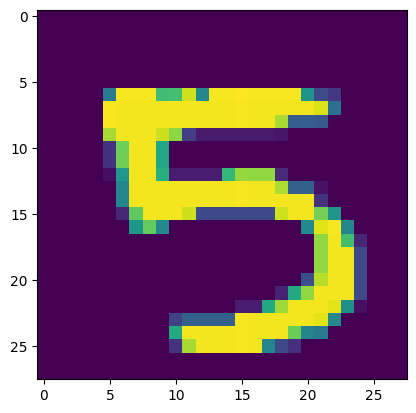

In [ ]:
plt.imshow(next(iter(train_loader))[0][42].permute(1,2,0).view(28,28))

In [ ]:
next(iter(train_loader))[0].view(128,-1).shape

torch.Size([128, 784])

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_in = torch.nn.Linear(in_features = 28 * 28 * 1, out_features = 256)
        self.fc_out = torch.nn.Linear(in_features = 256, out_features = 10)

    def forward(self, x):
        x = x.view(128, -1) # x.flatten(x, 1)
        x = torch.nn.functional.tanh(self.fc_in(x))
        x = self.fc_out(x)

        return x

In [ ]:
model = MLP()

In [ ]:
model = model.to(device) #send the model to GPU

In [ ]:
#what are we going to optimize?
criterion = torch.nn.CrossEntropyLoss() #if you have a classification task and don't know what to do - use `CrossEntropyLoss`

#how are we going to optimize it?
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #if you just don't know what to do - use `Adam` optimizer

In [ ]:
tensor = torch.randn(128,1,28,28)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
out = model(tensor.to(device))

In [ ]:
out

tensor([[-0.0925,  0.2607, -0.2534,  ...,  0.4515,  0.5489, -0.3756],
        [ 0.3964,  0.1080, -0.3444,  ..., -0.2719, -0.2838,  0.1526],
        [-0.1379,  0.0630, -0.2263,  ...,  0.3146, -0.3827, -0.2268],
        ...,
        [ 0.2278,  0.3566, -0.1924,  ..., -0.1818,  0.2352,  0.0861],
        [-0.1258, -0.1591, -0.3404,  ...,  0.0079,  0.1554, -0.0720],
        [ 0.1570,  0.0949, -0.5522,  ...,  0.1467,  0.1344,  0.4803]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
criterion(out, batch[1].cuda())

tensor(2.3812, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
60000 - len(train_loader)*128

96

In [ ]:
len(train_dataset)

60000

In [ ]:
training_progress_loss = []
training_progress_accuracy = []

model.train() #this helps certain layers to differenciate training and evaluation mode, you'll learn about it later
for epoch in range(10):

    print("Epoch: ", epoch)

    train_loss = 0
    train_correct = 0

    for data, target in train_loader: # training per batch

        data, target = data.to(device), target.to(device) #send to GPU
        output = model(data)

        loss = criterion(output, target)
        train_loss += loss.item()

        _, preds = torch.max(output.data, 1)
        train_correct += torch.sum(preds == target).item()

        loss.backward() #calculate backpropagation path
        optimizer.step() #take a step on the loss surface
        optimizer.zero_grad() #we typically want to set the gradients to zero because PyTorch accumulates the gradients (we can leverage it!!!).

    train_loss /= len(train_loader) #divide by the number of batches in the loader
    training_progress_loss.append(train_loss)
    training_progress_accuracy.append(train_correct/len(train_dataset))
    print("Accuracy: ", train_correct/len(train_dataset))

Epoch:  0
Accuracy:  0.8926333333333333
Epoch:  1
Accuracy:  0.9477333333333333
Epoch:  2
Accuracy:  0.96245
Epoch:  3
Accuracy:  0.9693166666666667
Epoch:  4
Accuracy:  0.97545
Epoch:  5
Accuracy:  0.9776333333333334
Epoch:  6
Accuracy:  0.9804166666666667
Epoch:  7
Accuracy:  0.9823833333333334
Epoch:  8
Accuracy:  0.9848333333333333
Epoch:  9
Accuracy:  0.9852666666666666


In [ ]:
training_progress_loss = []
training_progress_accuracy = []

val_progress_loss = []
val_progress_accuracy = []

model.train() #this helps certain layers to differenciate training and evaluation mode, you'll learn about it later
for epoch in range(10):

    print("Epoch: ", epoch)

    train_loss = 0
    train_correct = 0

    for data, target in train_loader: # training per batch

        data, target = data.to(device), target.to(device) #send to GPU
        output = model(data)

        loss = criterion(output, target)
        train_loss += loss.item()

        _, preds = torch.max(output.data, 1)
        train_correct += torch.sum(preds == target).item()

        loss.backward() #calculate backpropagation path
        optimizer.step() #take a step on the loss surface
        optimizer.zero_grad() #we typically want to set the gradients to zero because PyTorch accumulates the gradients (we can leverage it!!!).

    train_loss /= len(train_loader) #divide by the number of batches in the loader
    training_progress_loss.append(train_loss)
    training_progress_accuracy.append(train_correct/len(train_dataset))
    print("Training Accuracy: ", train_correct/len(train_dataset))

    val_loss = 0
    val_correct = 0

    with torch.no_grad():

      for data, target in val_loader: # training per batch

          data, target = data.to(device), target.to(device) #send to GPU
          output = model(data)

          loss = criterion(output, target)
          val_loss += loss.item()

          _, preds = torch.max(output.data, 1)
          val_correct += torch.sum(preds == target).item()

      val_loss /= len(val_loader) #divide by the number of batches in the loader
      val_progress_loss.append(val_loss)
      val_progress_accuracy.append(val_correct/len(val_dataset))
      print("Validation Accuracy: ", val_correct/len(val_dataset))

Epoch:  0
Training Accuracy:  0.8939333333333334
Validation Accuracy:  0.9409
Epoch:  1
Training Accuracy:  0.9475166666666667
Validation Accuracy:  0.9556
Epoch:  2
Training Accuracy:  0.9618833333333333
Validation Accuracy:  0.963
Epoch:  3
Training Accuracy:  0.9702333333333333
Validation Accuracy:  0.9689
Epoch:  4
Training Accuracy:  0.9746333333333334
Validation Accuracy:  0.9692
Epoch:  5
Training Accuracy:  0.9774833333333334
Validation Accuracy:  0.9725
Epoch:  6
Training Accuracy:  0.9802666666666666
Validation Accuracy:  0.9704
Epoch:  7
Training Accuracy:  0.9831166666666666
Validation Accuracy:  0.971
Epoch:  8
Training Accuracy:  0.9851
Validation Accuracy:  0.9738
Epoch:  9
Training Accuracy:  0.9852333333333333
Validation Accuracy:  0.975


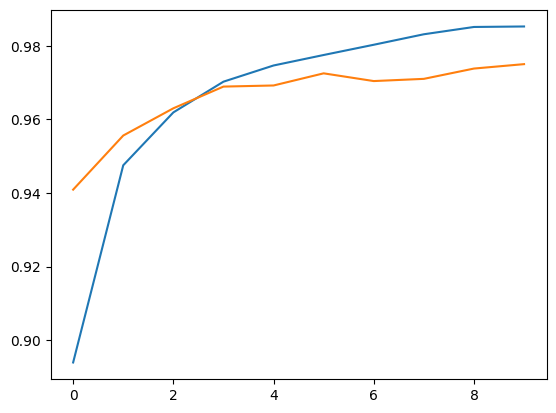

In [ ]:
plt.plot(training_progress_accuracy)
plt.plot(val_progress_accuracy)

Now, when we can see that it learns something, try to implement your own validation loop (use `model.eval()` or `@torch.no_grad()`) ! If you are quick, close your social network tab 🧐, overfit your model badly, and implement Early Stopping algorithm!

## What about regularization techniques?

In [ ]:
class SuperMLP(torch.nn.Module):
    def __init__(self, hidden_dim = 512):
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 10)
        self.dropout = torch.nn.Dropout(p = 0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
model = SuperMLP().to(device)

In [ ]:
def train_test(loader = train_loader,
               model = model,
               dataset = train_dataset,
               criterion = criterion,
               device = device,
               state = 'train'
               ):

    if state == 'train':
        model.train()
    elif state == 'eval':
        model.eval()
    else:
        print('State should be either "eval" or "train"')

    train_loss = 0
    train_correct = 0

    for data, target in loader:

        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        _, preds = torch.max(output.data, 1)

        train_loss += loss.item()
        train_correct += torch.sum(preds == target).item()

        if state == 'train':

            loss.backward()
            optimizer.step()
            model.zero_grad()

    train_loss /= len(loader)
    train_correct /= len(dataset)

    return train_loss, train_correct

In [ ]:
#what are we going to optimize?
criterion = torch.nn.CrossEntropyLoss() #if you have a classification task and don't know what to do - use `CrossEntropyLoss`

#how are we going to optimize it?
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001) #if you just don't know what to do - use `Adam` optimizer

In [ ]:
train_accuracies = []
test_accuracies = []

for epoch in range(3):

    train_loss, train_acc = train_test(state = 'train')
    test_loss, test_acc = train_test(loader = test_loader, dataset = test_dataset, state = 'eval')

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

In [ ]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)

Try to paly with various `Dropout` rate. Add more regularization layers, such as: [`BatchNorm`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) or [`LayerNorm`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

## Custom Loss function

In [ ]:
def my_cross_entropy(output, target):
    log_prob = -1.0 * torch.nn.functional.log_softmax(output, 1)
    loss = log_prob.gather(1, target.unsqueeze(1))
    loss = loss.mean()
    return loss

## Custom Activation Function

In [ ]:
def torch_logistic(z):
    return 1. / (1. + torch.exp(-z))

# Convolutional Neural Networks

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#upload an image
image = cv2.imread('/content/drive/MyDrive/MVI/B211/pewpew.jpeg')

In [ ]:
image.shape

(1000, 750, 3)

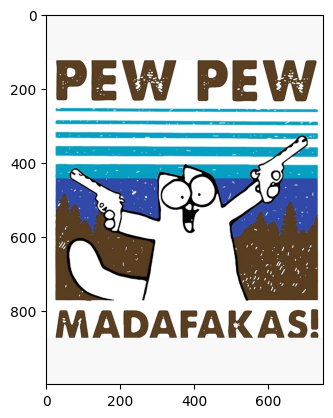

In [ ]:
plt.imshow(image, cmap="Greys_r")

In [ ]:
image.shape

(1000, 750, 3)

In [ ]:
#make it black and white
image_mono = image.mean(axis = 2)

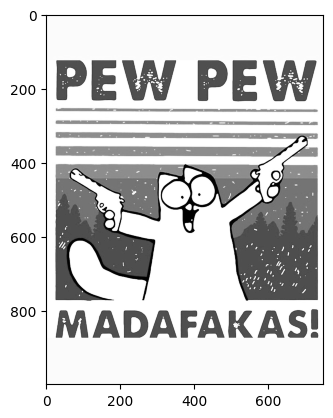

In [ ]:
plt.imshow(image_mono, cmap="Greys_r")

In [ ]:
def filter2d(image, kernel):

    output = np.zeros_like(image)

    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    image_padded[1:-1, 1:-1] = image

    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[y, x]=(kernel * image_padded[y: y+3, x: x+3]).sum()

    return output

In [ ]:
kernel = np.array([[1, 0, 1],
                   [1, 5, -1],
                   [1, 0, -1]])

In [ ]:
image_output = filter2d(image_mono, (kernel.T+kernel))

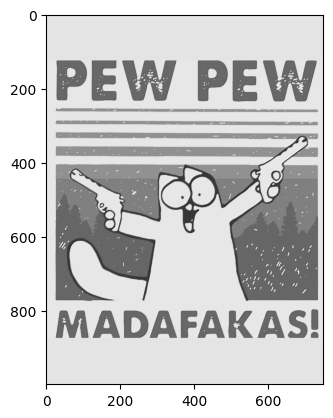

In [ ]:
plt.imshow(image_output, cmap = 'Greys_r')

In [ ]:
img = cv2.filter2D(image, -1, kernel)

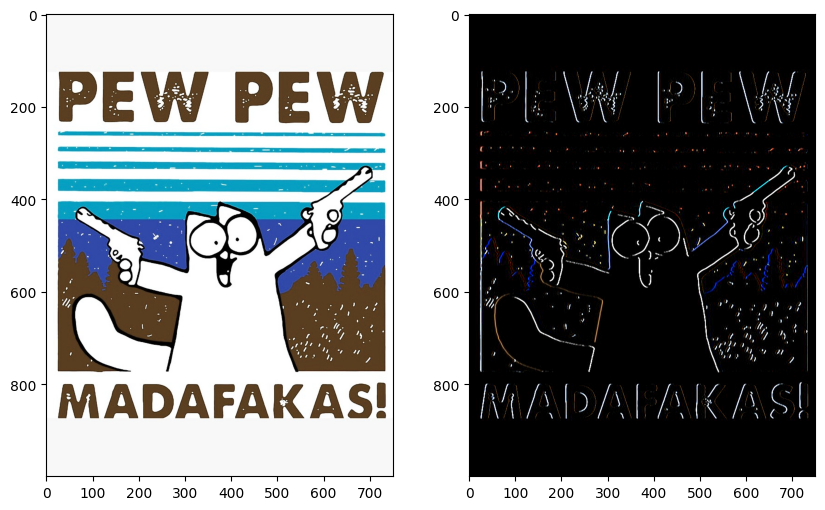

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(img)

## Lets upload more sophisticated dataset and try MLP!

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root = './data',
                                        train = True,
                                        download = True,
                                        transform = transform
                                        )


trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 128,
                                          shuffle = True,
                                          drop_last = True
                                          )

testset = torchvision.datasets.CIFAR10(root = './data',
                                       train = False,
                                       download = True,
                                       transform = transform
                                       )

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 128,
                                         shuffle = False,
                                         drop_last = True
                                         )

classes = ('plane',
           'car',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck'
           )

100%|██████████| 170498071/170498071 [00:02<00:00, 71981197.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


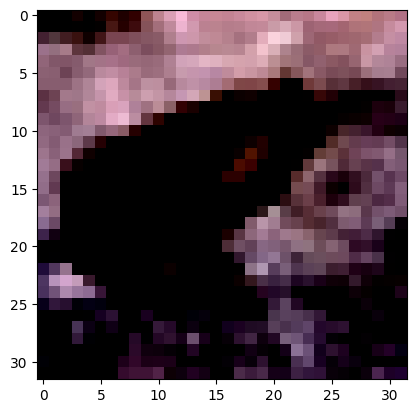

In [ ]:
plt.imshow(next(iter(trainloader))[0][42].permute(1,2,0))

### MLP doean't work so well 😭

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3), padding = 1, stride=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, padding = 1, kernel_size=(3,3))
        self.fc1 = nn.Linear(in_features=16 * 8 * 8, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
model = CNN()

In [ ]:
model(torch.randn(1,3,32,32))

tensor([[-0.0364,  0.0756,  0.0251, -0.1031,  0.0715,  0.0089, -0.1287,  0.0894,
          0.0871, -0.0003]], grad_fn=<AddmmBackward0>)

In [ ]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3), padding =1,  stride=(1,1))

In [ ]:
conv2 = nn.Conv2d(in_channels=6, out_channels=16, padding =1, kernel_size=(3,3))

In [ ]:
nn.MaxPool2d(2,2)(conv1(torch.randn(1,3,32,32))).shape

torch.Size([1, 6, 16, 16])

In [ ]:
nn.MaxPool2d(2,2)(conv2(nn.MaxPool2d(2,2)(conv1(torch.randn(1,3,32,32))))).shape

torch.Size([1, 16, 8, 8])

### Dive into weight initialization:

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)

In [ ]:
model = CNN()

In [ ]:
model = model.apply(initialize_weights)

In [ ]:
model = model.to("cuda")

In [ ]:
model.conv1.weight[0]

tensor([[[ 0.5808,  0.4969, -0.4665],
         [-0.3223, -0.5013, -0.3086],
         [-0.4761, -0.3766,  0.3528]],

        [[ 0.4884,  0.3088,  0.0074],
         [ 0.1926,  0.2405, -0.2903],
         [-0.1357, -0.2826,  0.5197]],

        [[ 0.1480, -0.2434,  0.1515],
         [-0.2776, -0.4558, -0.4032],
         [-0.4146,  0.3669,  0.0873]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
model.conv1.weight[0]

tensor([[[ 0.3401,  0.4056, -0.4358],
         [-0.4180, -0.3786, -0.2421],
         [-0.3765, -0.4185,  0.0136]],

        [[ 0.2561,  0.2053,  0.0871],
         [ 0.1219,  0.3681, -0.2357],
         [-0.0226, -0.3025,  0.2994]],

        [[-0.0476, -0.3486,  0.2195],
         [-0.4066, -0.4376, -0.4125],
         [-0.3879,  0.3804, -0.1361]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
def train(model, train_loader, optimizer):
    global device, epoch
    model.train()
    train_loss = 0
    train_correct = 0
    bnum = 0

    model.zero_grad()
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        loss = criterion(output, target)

        _, preds = torch.max(output.data, 1)

        train_loss += loss.item()
        train_correct += torch.sum(preds == target).item()

        loss.backward()
        optimizer.step()
        model.zero_grad()

    train_loss /= len(train_loader)

    print('\nTrain loss: {:.4f}'.format(
        train_loss,
        )
    )
    print('Train Accuracy: {:.2f} %'.format(
        train_correct/len(trainset)*100,
        )
    )

    return train_loss, train_correct/len(trainset)*100

In [ ]:
def test(model, test_loader):
    global device
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for data, target in test_loader:

            data = data.to(device)
            target = target.to(device)

            output = model(data)

            test_loss += criterion(output, target).item()

            _, preds = torch.max(output.data, 1)

            test_correct += torch.sum(preds == target).item()

    test_loss /= len(test_loader)

    print('\nValidation loss: {:.4f}'.format(
        test_loss
        )
    )
    print('Validation Accuracy: {:.2f} %'.format(
        test_correct/len(testset)*100,
        )
    )

    return test_loss, test_correct/len(testset)*100

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20, eta_min = 0, verbose = False)

In [ ]:
num_epochs = 20
train_loss_output = []
val_loss_output = []

for epoch in range(1, num_epochs + 1):
    tr_loss = train(model=model,
                    train_loader=trainloader,
                    optimizer=optimizer
                    )
    vl_loss = test(model, testloader)

    train_loss_output.append(tr_loss)
    val_loss_output.append(vl_loss)


Train loss: 1.6071
Train Accuracy: 42.05 %

Validation loss: 1.4073
Validation Accuracy: 49.63 %

Train loss: 1.3251
Train Accuracy: 52.94 %

Validation loss: 1.2923
Validation Accuracy: 54.47 %

Train loss: 1.2139
Train Accuracy: 56.94 %

Validation loss: 1.2201
Validation Accuracy: 56.57 %

Train loss: 1.1323
Train Accuracy: 59.97 %

Validation loss: 1.2128
Validation Accuracy: 56.70 %

Train loss: 1.0666
Train Accuracy: 62.28 %

Validation loss: 1.1607
Validation Accuracy: 59.42 %

Train loss: 1.0106
Train Accuracy: 64.46 %

Validation loss: 1.1184
Validation Accuracy: 61.29 %

Train loss: 0.9660
Train Accuracy: 65.76 %

Validation loss: 1.1060
Validation Accuracy: 61.38 %

Train loss: 0.9207
Train Accuracy: 67.53 %

Validation loss: 1.1216
Validation Accuracy: 61.24 %

Train loss: 0.8803
Train Accuracy: 69.12 %

Validation loss: 1.1091
Validation Accuracy: 61.68 %

Train loss: 0.8433
Train Accuracy: 70.22 %

Validation loss: 1.1340
Validation Accuracy: 61.93 %

Train loss: 0.8161


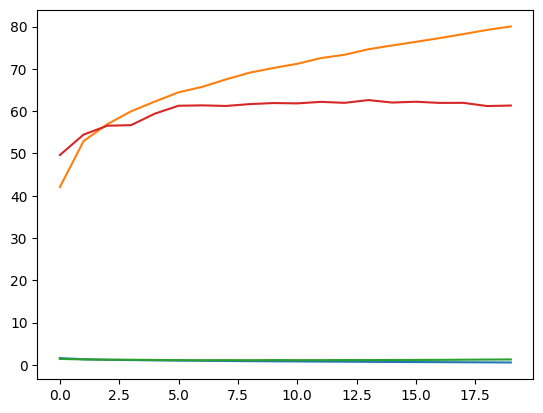

In [ ]:
plt.plot(train_loss_output)
plt.plot(val_loss_output)

## How to save/load your model?

In [ ]:
torch.save(model.state_dict(), './nameyormodel.pth')

In [ ]:
model.load_state_dict(torch.load('./nameyormodel.pth'))

# Transfer Learning Allmighty!

In [ ]:
!pip install timm

In [ ]:
import timm

In [ ]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
import torch.nn as nn

In [ ]:
model = timm.create_model('densenetblur121d', pretrained = True) #'convnext_small_384_in22ft1k'

model.classifier.out_features = 10

In [ ]:
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

In [ ]:
for p in model.parameters():
  p.requires_grad = False

In [ ]:
for p in model.parameters():
  print(p)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 6, eta_min = 0, verbose = False)

In [ ]:
model = model.to(device)

In [ ]:
num_epochs = 6
train_loss_output = []
val_loss_output = []

for epoch in range(1, num_epochs + 1):
    print('Epoch: ')
    tr_loss = train(model=model,
                    train_loader=trainloader,
                    optimizer=optimizer
                    )
    vl_loss = test(model, testloader)

    train_loss_output.append(tr_loss)
    val_loss_output.append(vl_loss)

In [ ]:
plt.imshow(model.conv1.weight[0].permute(1,2,0).cpu().detach().numpy())

# ⚠️⚠️⚠️ Homework ⚠️⚠️⚠️

* Implement and train small CNN with 2-3 convolutional blocks on CIFAR or any other dataset with color images. Now take trained filters and apply selected filters to an arbitrary high resolution image of your choice. Observe and interpret the results. How does the filter's locality change with the layer depth in the CNN?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
net = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Save the trained model
torch.save(net.state_dict(), 'cifar_cnn.pth')


Files already downloaded and verified
[1,  2000] loss: 2.254
[1,  4000] loss: 2.079
[1,  6000] loss: 1.985
[1,  8000] loss: 1.883
[1, 10000] loss: 1.829
[1, 12000] loss: 1.783
[2,  2000] loss: 1.742
[2,  4000] loss: 1.739
[2,  6000] loss: 1.690
[2,  8000] loss: 1.648
[2, 10000] loss: 1.651
[2, 12000] loss: 1.602
[3,  2000] loss: 1.624
[3,  4000] loss: 1.576
[3,  6000] loss: 1.549
[3,  8000] loss: 1.525
[3, 10000] loss: 1.532
[3, 12000] loss: 1.477
[4,  2000] loss: 1.466
[4,  4000] loss: 1.451
[4,  6000] loss: 1.445
[4,  8000] loss: 1.424
[4, 10000] loss: 1.404
[4, 12000] loss: 1.394
[5,  2000] loss: 1.382
[5,  4000] loss: 1.364
[5,  6000] loss: 1.359
[5,  8000] loss: 1.340
[5, 10000] loss: 1.324
[5, 12000] loss: 1.320
Finished Training


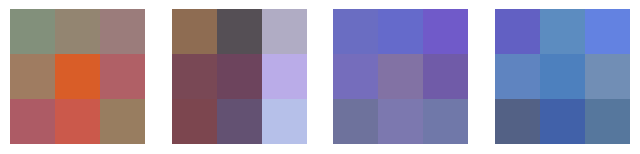

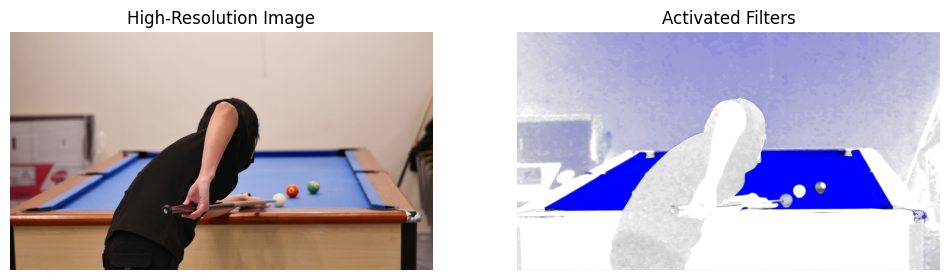

In [ ]:
import cv2
import numpy as np

# Load the trained model
net = SimpleCNN() #init an instance of CNN model
net.load_state_dict(torch.load('cifar_cnn.pth')) #load the trained weights of the cnn
net.to(device) #move model to specified device (CPU/GPU)
net.eval() # sets model to evaluation mode

# Extract and visualize filters from the first convolutional layer
filters = net.conv1.weight.data.cpu().numpy()
filter_indices = [0, 1, 2, 3]  # Choose some filters to visualize

plt.figure(figsize=(8, 8))
for i, filter_index in enumerate(filter_indices, 1):
    plt.subplot(1, len(filter_indices), i)
    plt.imshow(filters[filter_index].transpose(1, 2, 0) * 0.5 + 0.5)
    plt.axis('off')
plt.show()

# Load an arbitrary high-resolution image
image = cv2.imread('P1340276.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transforms.ToTensor()(image)
image = image.unsqueeze(0).to(device)

# Apply selected filters to the high-resolution image
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))

with torch.no_grad():
    _ = net(image)

selected_activation = activation['conv1']
selected_filters = selected_activation[:, filter_indices]

# Visualize the high-resolution image and the activated filters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
plt.title('High-Resolution Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(selected_filters.cpu().squeeze().permute(1, 2, 0).numpy())
plt.title('Activated Filters')
plt.axis('off')

plt.show()
